In [1]:
import os
import pickle

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scripts import constants
from sklearn.cluster import KMeans

In [2]:
dataset = "mcfarland_2020"
split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
label_key = constants.DATASET_SPLIT_LOOKUP[dataset]["label_key"]

methods = [
    "scVI",
    "CPLVM",
    "CGLVM",
    "contrastiveVI",
]

latent_size = 10

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    ),
)

target_adata = adata[adata.obs[split_key] != background_value]
background_adata = adata[adata.obs[split_key] == background_value]

target_labels = target_adata.obs[label_key]
target_unique_labels = target_adata.obs[label_key].unique().tolist()
styled_target_labels = [label.replace("_", "-").capitalize() for label in target_unique_labels]
styled_target_labels = [label.replace("Mutation", "Mutant") for label in styled_target_labels]
styled_target_labels = ["$\it{TP53}$ " + label for label in styled_target_labels]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
method_latent_adata_dict = {}
for method in methods:
    print(f"Getting AnnData for {method}...")
    for seed in tqdm(constants.DEFAULT_SEEDS):
        latent = np.load(
            os.path.join(
                constants.DEFAULT_RESULTS_PATH,
                dataset,
                method,
                f"latent_{latent_size}",
                f"{seed}",
                "latent_representations.npy",
            ),
        )
        latent_adata = ad.AnnData(
            X=latent,
            obs=target_adata.obs,
            var=pd.DataFrame(
                index=[f"latent_dim_{i}" for i in range(latent.shape[1])]
            ),
        )
        
        sc.pp.neighbors(latent_adata)
        sc.tl.umap(latent_adata)
        sc.pp.pca(latent_adata, n_comps=2)
        
        if method not in method_latent_adata_dict.keys():
            method_latent_adata_dict[method] = {}
        
        method_latent_adata_dict[method][seed] = latent_adata

Getting AnnData for scVI...


100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.44s/it]


Getting AnnData for CPLVM...


100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.29s/it]


Getting AnnData for CGLVM...


100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.72s/it]


Getting AnnData for contrastiveVI...


100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.31s/it]


In [5]:
performance_df = pd.read_csv(
    os.path.join(constants.DEFAULT_RESULTS_PATH, "performance_summary.csv"),
)
performance_df = performance_df[
    (performance_df["dataset"] == dataset)
    & (performance_df["latent_size"] == latent_size)
]

results_dict = {
    method: {
        "silhouette": {},
        "adjusted_random_index": {},
        "adjusted_mutual_info": {},
    } for method in methods
}
for method in methods:
    for metric in results_dict[method].keys():
        method_metrics = performance_df[
            performance_df["method"] == method
        ][metric].tolist()
    
        results_dict[method][metric] = {
            "mean": np.mean(method_metrics),
            "std": np.std(method_metrics),
        }
        results_dict[method][metric]["stderr"] = (
            results_dict[method][metric]["std"] / np.sqrt(len(method_metrics))
        )

In [11]:
target_label_palette = ["lightcoral", "black"]

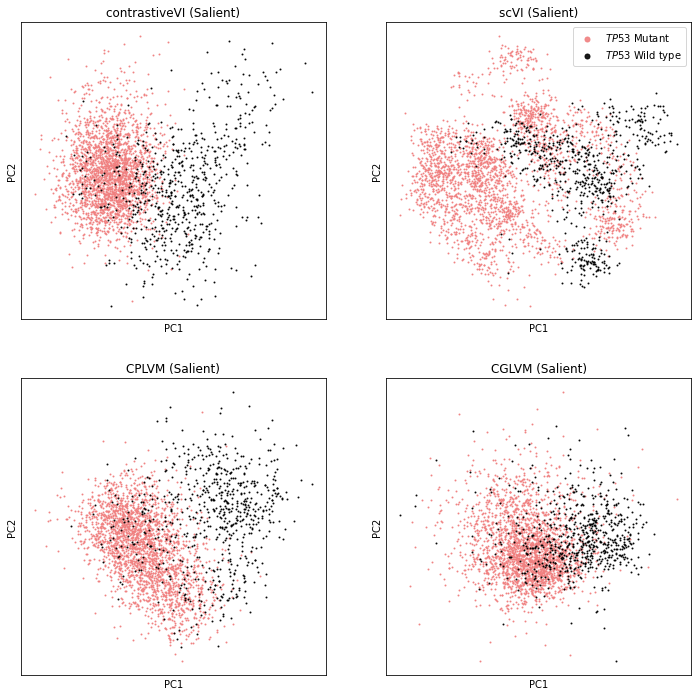

In [15]:
seed = 789
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
method_rep_ax= {
    "contrastiveVI": 0,
    "scVI": 1,
    "CPLVM": 2,
    "CGLVM": 3,

}

for method, axis_idx in method_rep_ax.items():
    rep = method_latent_adata_dict[method][seed].obsm["X_pca"]
    for i, label in enumerate(target_unique_labels):
        axes[axis_idx].scatter(
            rep[:, 0][target_labels == label],
            rep[:, 1][target_labels == label],
            s=1,
            label=styled_target_labels[i],
            color=target_label_palette[i],
            alpha=0.9,
        )
    axes[axis_idx].set_title(f"{method} (Salient)")
    axes[axis_idx].set_xticks([])
    axes[axis_idx].set_yticks([])
    axes[axis_idx].set_xlabel("PC1")
    axes[axis_idx].set_ylabel("PC2")
    if axis_idx == 1:
        axes[axis_idx].legend(
            markerscale=5, loc="upper right"
        )
plt.show()

In [8]:
contrastive_vi_latent_clusters = (
    KMeans(n_clusters=2, random_state=123)
    .fit(method_latent_adata_dict["contrastiveVI"][seed].X)
    .labels_
)

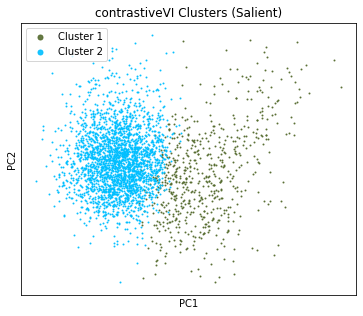

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
latent_cluster_palette = ["darkolivegreen", "deepskyblue"]

method = "contrastiveVI"
rep = method_latent_adata_dict[method][seed].obsm["X_pca"]
for i, cluster in enumerate(np.unique(contrastive_vi_latent_clusters)):
    ax.scatter(
        rep[:, 0][contrastive_vi_latent_clusters == cluster],
        rep[:, 1][contrastive_vi_latent_clusters == cluster],
        s=1,
        label=f"Cluster {i + 1}",
        color=latent_cluster_palette[i],
        alpha=0.9,
    )
ax.set_title(f"{method} Clusters (Salient)")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(
    markerscale=5, loc="upper left"
)

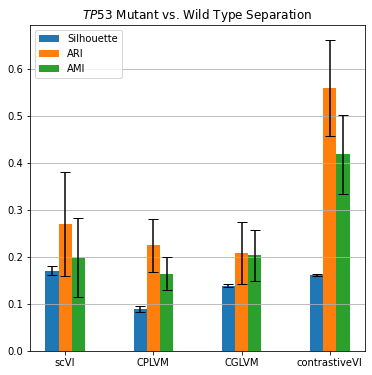

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
width = 0.15  # Bar width
capsize = 5  # Error bar width
var_statistic = "stderr"

plot_ordered_methods = [
    "CPLVM",
    "CGLVM",
    "scVI",
    "contrastiveVI",
]
x = np.arange(len(plot_ordered_methods))

ax.bar(
    x,
    [results_dict[method]["silhouette"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["silhouette"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="Silhouette",
)
ax.bar(
    x + width,
    [results_dict[method]["adjusted_random_index"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["adjusted_random_index"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="ARI",
)
ax.bar(
    x + width * 2,
    [results_dict[method]["adjusted_mutual_info"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["adjusted_mutual_info"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="AMI",
)

ax.set_xticks(x + width)
ax.set_xticklabels(methods)
ax.legend(loc="upper left")
ax.grid(axis="y")
ax.set_title("$\it{TP53}$ Mutant vs. Wild Type Separation")
plt.show()